In [1]:
import pandas as pd
import numpy as np
import eda
import visualization as viz
import feature_engineering as fe
import process_data as pr
import modeling as md

from sklearn.model_selection import StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

model_number = 'catboost_baseline'

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.sample(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
11577,11577,C,83.07,material_7,material_8,5,8,1,13,7,...,9.617,15.165,20.565,15.089,16.391,15.273,15.545,17.303,580.846,0
7959,7959,B,99.26,material_5,material_5,8,8,8,7,8,...,10.406,16.849,21.799,11.142,16.404,15.721,12.576,17.699,631.140,0
2384,2384,A,113.43,material_7,material_8,9,5,6,0,7,...,13.264,15.580,17.422,13.735,15.524,17.186,15.445,17.777,590.660,1


In [3]:
# Drop the id columns
dropped_columns = ['id', 'product_code']

df_train_model = df_train.drop(dropped_columns, axis=1)
df_test_model = df_test.drop(dropped_columns, axis=1)

# Assign train and test for X and y
X_train = df_train_model.drop('failure', axis=1)
y_train = df_train_model['failure']

X_test = df_test_model.copy()

In [4]:
cat_features = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
continous_features = [cat for cat in X_train.columns if cat not in cat_features]
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns

In [5]:
target = 'failure'

combined_df = pd.concat([X_train, X_test])
combined_df.sample(2)

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
3123,90.96,material_5,material_6,6,4,7,8,16,16.397,12.518,...,NaN,10.567,16.387,19.350,11.904,17.352,NaN,14.700,18.972,995.639
22749,270.90,material_7,material_6,6,9,2,13,3,17.858,12.317,...,17.858,12.419,15.373,19.293,11.130,14.267,18.858,15.027,15.784,650.841


Learning rate set to 0.067421
0:	learn: 0.6674114	test: 0.6674808	best: 0.6674808 (0)	total: 216ms	remaining: 3m 36s
100:	learn: 0.4925058	test: 0.5106587	best: 0.5104251 (73)	total: 4.72s	remaining: 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5104250543
bestIteration = 73

Shrink model to first 74 iterations.
Learning rate set to 0.067421
0:	learn: 0.6675357	test: 0.6677275	best: 0.6677275 (0)	total: 46.8ms	remaining: 46.7s
100:	learn: 0.4906094	test: 0.5097754	best: 0.5094702 (70)	total: 5.43s	remaining: 48.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5094701754
bestIteration = 70

Shrink model to first 71 iterations.
Learning rate set to 0.067421
0:	learn: 0.6672500	test: 0.6678302	best: 0.6678302 (0)	total: 56.5ms	remaining: 56.5s
100:	learn: 0.4921939	test: 0.5122158	best: 0.5113403 (51)	total: 5.77s	remaining: 51.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5113402583
bestIteration = 51

Shrink mod

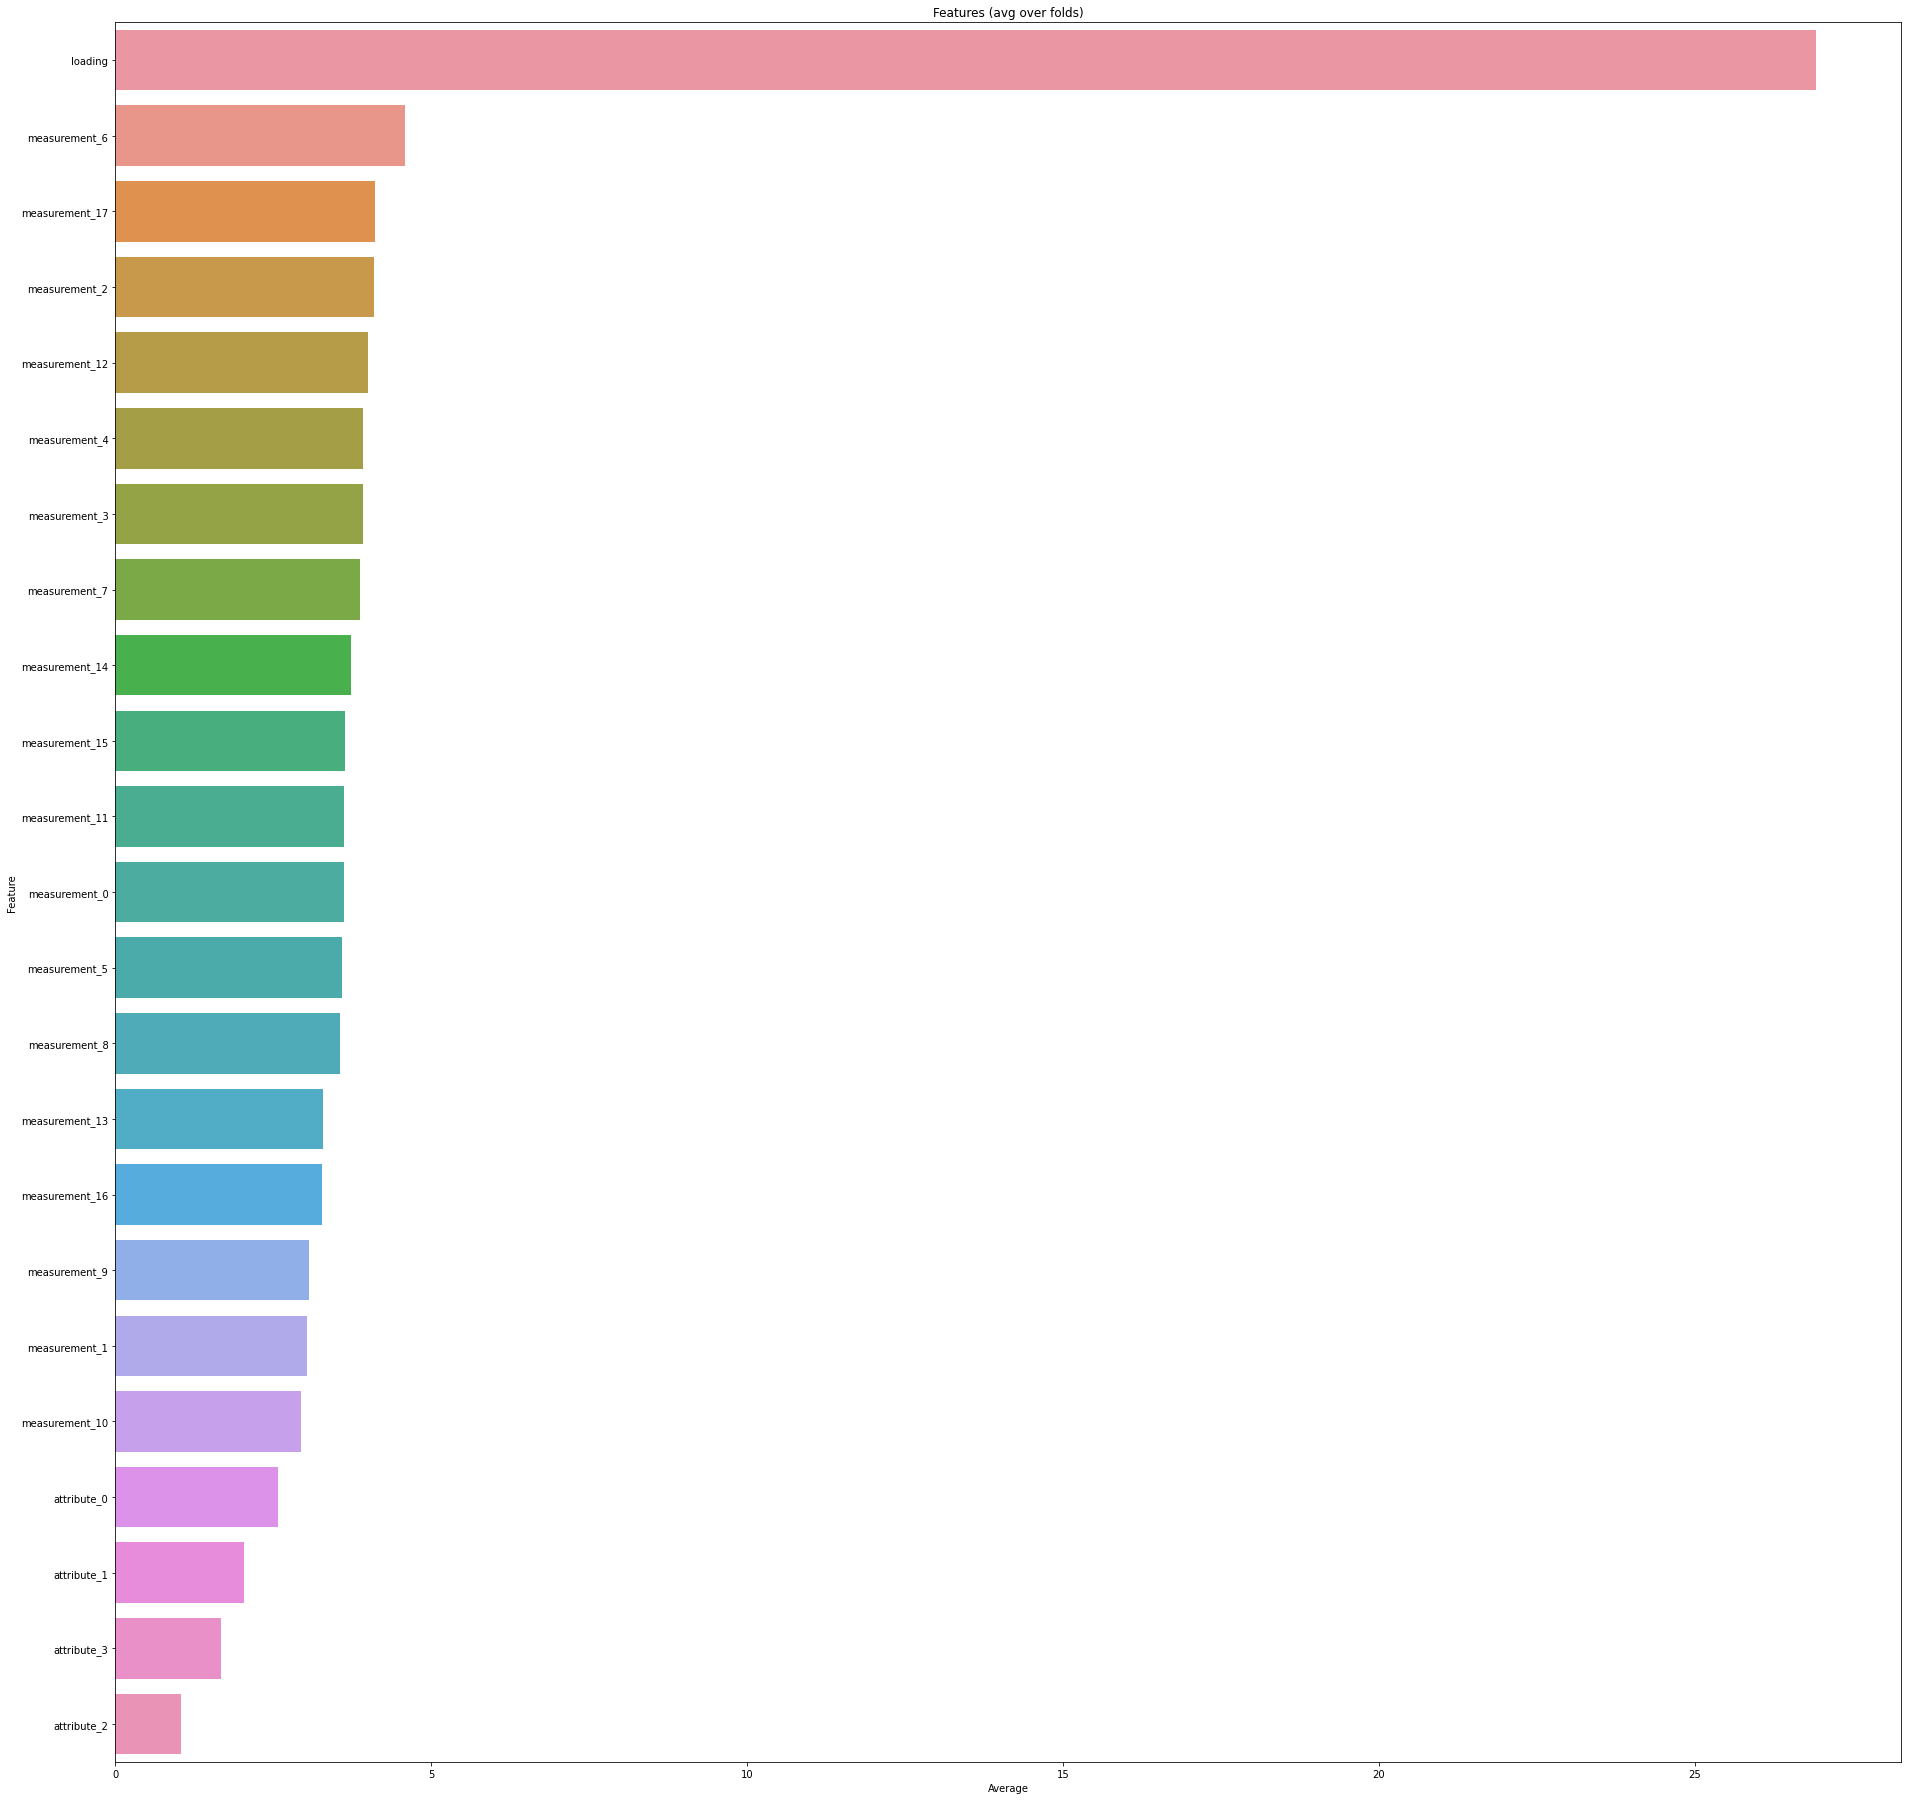

In [6]:
viz.plot_catboost_feature_importance(X_train, y_train, cat_features=cat_features, figsize=(32, 32))

In [ ]:
mi_df = fe.make_mi_scores_classification(X_train[numerical_features], y_train)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mi_df.sort_values(by='Average', ascending=False, inplace=True)

plt.figure(figsize=(32, 32))
sns.barplot(
    x=mi_df['MI Score'],
    y=mi_df['Feature'],
)

plt.title('MI Score')
plt.show()

In [7]:
# Initialize CatBoost model
model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1','attribute_2', 'attribute_3'], verbose=False)
# model = CatBoostClassifier(random_state=5, verbose=False)

num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=5)

# scores = cross_val_score(model, X_train.drop(dropped_columns_low_fi, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, scoring='roc_auc')

list(scores), scores.mean(), scores.std()

([0.5606357007025597,
  0.5657536506539873,
  0.5544721568892874,
  0.5593021878542784,
  0.5702905294505829],
 0.5620908451101392)

In [8]:
scores.std()

0.00545141142235811

In [ ]:
# Fit the model on the entire training data
# model.fit(X_train.drop(dropped_columns_low_fi, axis=1), y_train)
model.fit(X_train, y_train)

# Predict on the X_test data
# predictions = model.predict_proba(X_test.drop(dropped_columns_low_fi, axis=1))[:, 1]
predictions = model.predict_proba(X_test)[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame(
    {'id': df_test['id'],
    'failure': predictions})

# submission_df.head(50)
# Save to CSV for submission
submission_df.to_csv(f'submission_{model_number}.csv', index=False)